<a href="https://colab.research.google.com/github/KwonYN/TIL/blob/master/PYTHON/TENSORFLOW/Ch4_%EC%98%88%EC%A0%9C_05_CNN_MNIST_1_Conv_Layer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chapter4-2. CNN 기본연산

## [예제5] MNIST Handwrite - Classifier by CNN : 단일 Convolution Layer

> ### Load Module

In [30]:
%tensorflow_version 1.x

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.datasets import mnist

print("Module Loaded.")
print("NumPy Version :{}".format(np.__version__))
print("TensorFlow Version :{}".format(tf.__version__))
print("Matplotlib Version :{}".format(plt.matplotlib.__version__))

Module Loaded.
NumPy Version :1.17.4
TensorFlow Version :1.15.0
Matplotlib Version :3.1.2


> ### Load MNIST 

In [31]:
categories = 10 # 숫자 0 ~ 9이니까 10개의 카테고리

(train_data, train_labels), (test_data, test_labels) = mnist.load_data()
train_data_size = train_data.shape
print(train_data.shape, test_data.shape)

train_data = train_data.astype(np.float32)
train_data = np.expand_dims(train_data, axis = 3)  # 3차원에서 Channel까지 추가하여 4차원으로 늘었넹 : axis=-1은 가장 낮은 Dimension에 추가하라는 뜻
                                                   # 그럼 왜 해주나? : Convolution Layer의 input으로 shape=(batch, height, width, channel)을 넘겨주어야 하기 때문에
                                                   #                  (60000, 28, 28)애서 (60000, 28, 28, 1)으로 차원을 확장해주는 것임!!!
train_data = train_data / 255.0
print(train_data.shape)

test_data = test_data.astype(np.float32)
test_data = np.expand_dims(test_data, axis = -1)
test_data = test_data / 255.0
print(test_data.shape)

train_labels = train_labels.reshape((-1, 1))
test_labels = test_labels.reshape((-1, 1))

(60000, 28, 28) (10000, 28, 28)
(60000, 28, 28, 1)
(10000, 28, 28, 1)


> ### Hyper parameter

In [32]:
learning_rate = 0.001

N_epoch = 100
batch_size = 100
batch_count = train_data_size[0]//batch_size
print(batch_count)

600


> ### Placeholder

In [0]:
x_ph = tf.placeholder(tf.float32, shape=(None, 28, 28, 1), name="input")
labels_ph = tf.placeholder(tf.int32, shape=(None, 1), name="labels")

> ### Define Network as function

In [0]:
def network(x):

    print(x.shape)
    conv1 = tf.layers.conv2d(x, filters=32, kernel_size=3, padding='SAME', activation=tf.nn.sigmoid)  # Convolution 연산
    print(conv1.shape)

    pool1 = tf.layers.max_pooling2d(conv1, pool_size=2, strides=2)                                    # 위의 결과를 Pooling -> Subsampling (1/4크기로)
    
    flatten = tf.layers.flatten(pool1)
    logits = tf.layers.dense(flatten, 10) # single layer이니까 한 번의 layer연산(Convolution + Pooling)의 결과를 softmax 돌려서 확률 구할 것임!!
                                          # fully-connected layer
    hypothesis = tf.nn.softmax(logits)    # softmax 함수를 통해 0 ~ 9, 10개의 클래스에 대한 확률이 나올 것임!
    
    print("conv1 = ",conv1)
    print("pool1 = ",pool1)
    print("Flatten = ", flatten)
    print("logits = ", logits)
    print("hypothesis = ", hypothesis)

    return logits, hypothesis

> ### Hypothesis, Cost, Optimizer

In [42]:
print("labels_ph.shape =", labels_ph.shape)

# network의 결과로 나온 결과들에 대한 shape 주의하기!!
logits, hypothesis = network(x_ph)
labels_oh = tf.one_hot(labels_ph, categories) # cost를 계산하기 위하여!!
print("labels_oh.shape =",labels_oh.shape)

cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels_oh, logits))

optimizer = tf.train.AdamOptimizer(learning_rate)
train = optimizer.minimize(cost)

labels_ph.shape = (?, 1)
(?, 28, 28, 1)
(?, 28, 28, 32)
conv1 =  Tensor("conv2d_5/Sigmoid:0", shape=(?, 28, 28, 32), dtype=float32)
pool1 =  Tensor("max_pooling2d_5/MaxPool:0", shape=(?, 14, 14, 32), dtype=float32)
Flatten =  Tensor("flatten_5/Reshape:0", shape=(?, 6272), dtype=float32)
logits =  Tensor("dense_5/BiasAdd:0", shape=(?, 10), dtype=float32)
hypothesis =  Tensor("Softmax_5:0", shape=(?, 10), dtype=float32)
labels_oh.shape = (?, 1, 10)


> ### Accuracy, Plotting

In [0]:
def Accuracy(y:np.ndarray, t:np.ndarray)->np.float32:
    return np.mean(np.equal(np.argmax(y, axis=1).reshape((-1, 1)),t).astype(np.float32))


def Make_Result_Plot(suptitle:str, data:np.ndarray, label:np.ndarray, y_max:np.ndarray):
    fig_result, ax_result = plt.subplots(2,5,figsize=(20,8))
    fig_result.suptitle(suptitle)
    for idx in range(10):
        ax_result[idx//5][idx%5].imshow(data[idx].reshape(28, 28),cmap="binary")
        ax_result[idx//5][idx%5].set_title("test_data[{}] (label : {} / y : {})".format(idx, label[idx], y_max[idx]))

> ### Training 준비

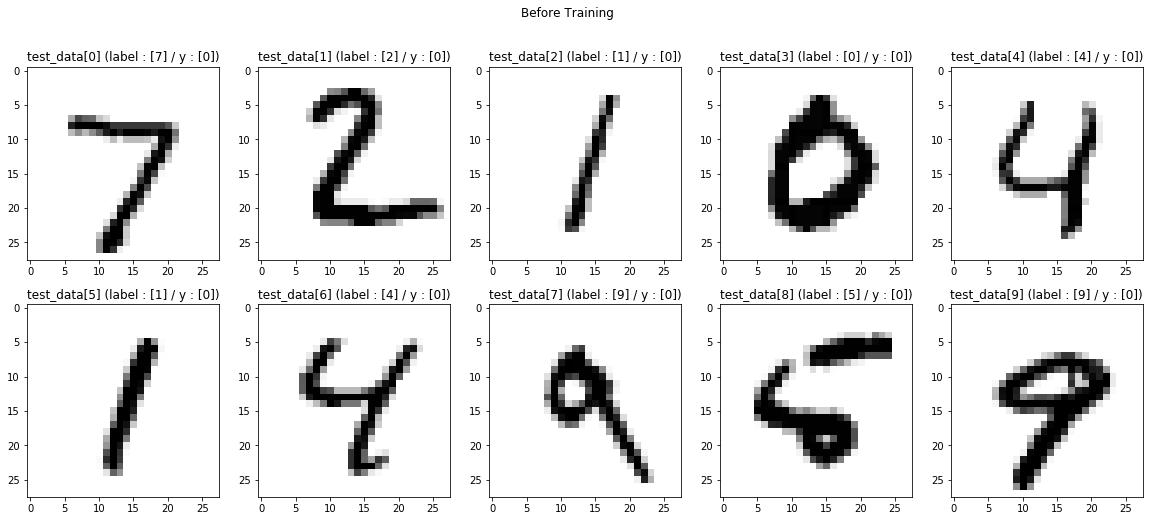

In [37]:
arr_epoch = []
arr_accu = []

# 학습 (Training)
sess = tf.Session()
sess.run(tf.global_variables_initializer())

train_data_idx = np.arange(train_data_size[0])

y_out = sess.run(hypothesis, feed_dict={x_ph: test_data})
y_max = np.argmax(y_out, axis=1).reshape((-1, 1))
Make_Result_Plot("Before Training", test_data, test_labels, y_max)
accu = Accuracy(y_out,test_labels)
arr_epoch.append(0)
arr_accu.append(accu)

> ### Training

In [38]:
%%time

for epoch_idx in range(1, N_epoch+1):
    np.random.shuffle(train_data_idx)
    for batch_idx in range(batch_count):
        batch_data = np.array([train_data[train_data_idx[batch_idx*batch_size+idx]] for idx in range(batch_size)])
        batch_labels = np.array([train_labels[train_data_idx[batch_idx*batch_size+idx]] for idx in range(batch_size)])
        sess.run(train, feed_dict={x_ph: batch_data, labels_ph: batch_labels})
    if epoch_idx%1 == 0:
        y_out = sess.run(hypothesis, feed_dict={x_ph: test_data})
        accu = Accuracy(y_out,test_labels)
        print("[{:>5}] accuracy = {:>10.4}".format(epoch_idx,accu))
        arr_epoch.append(epoch_idx)
        arr_accu.append(accu)

[    1] accuracy =     0.8781
[    2] accuracy =     0.9014
[    3] accuracy =     0.8925
[    4] accuracy =     0.9045
[    5] accuracy =     0.9241
[    6] accuracy =     0.9137
[    7] accuracy =     0.9414
[    8] accuracy =     0.9398
[    9] accuracy =     0.9515
[   10] accuracy =     0.9553
[   11] accuracy =     0.9616
[   12] accuracy =     0.9538
[   13] accuracy =     0.9651
[   14] accuracy =      0.969
[   15] accuracy =     0.9653
[   16] accuracy =     0.9664
[   17] accuracy =     0.9724
[   18] accuracy =     0.9697
[   19] accuracy =     0.9761
[   20] accuracy =     0.9736
[   21] accuracy =     0.9769
[   22] accuracy =      0.974
[   23] accuracy =     0.9783
[   24] accuracy =     0.9782
[   25] accuracy =     0.9752
[   26] accuracy =     0.9768
[   27] accuracy =     0.9779
[   28] accuracy =     0.9774
[   29] accuracy =     0.9786
[   30] accuracy =     0.9764
[   31] accuracy =     0.9778
[   32] accuracy =     0.9787
[   33] accuracy =     0.9791
[   34] ac

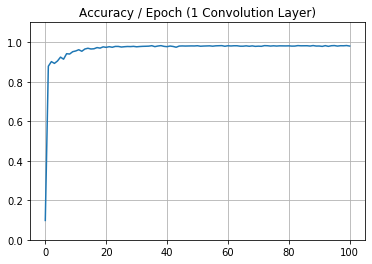

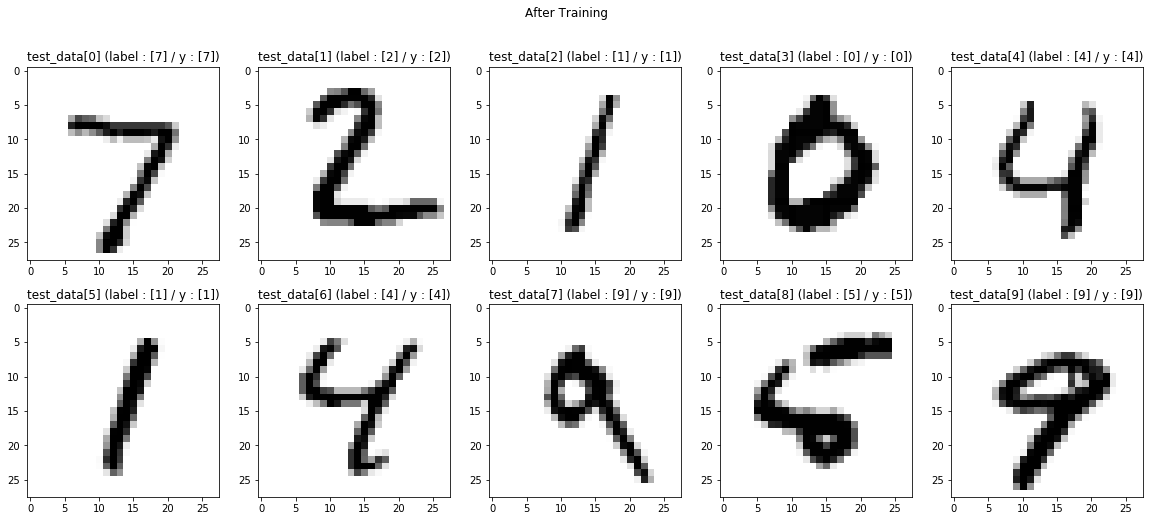

In [39]:
# Plot : Accuracy / Epoch
fig_cost, ax_cost = plt.subplots()
ax_cost.plot(arr_epoch, arr_accu)
ax_cost.set_title("Accuracy / Epoch (1 Convolution Layer)")
ax_cost.grid(True)
ax_cost.set_ylim(0,1.1)

y_out = sess.run(hypothesis, feed_dict={x_ph: test_data})
y_max = np.argmax(y_out, axis=1).reshape((-1, 1))
Make_Result_Plot("After Training", test_data, test_labels, y_max)

plt.show()